In [2]:
import shap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lime
import lime.lime_tabular
from xgboost import XGBClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# visualisation of the decision tree
from matplotlib import pyplot as plt

In [3]:
# load the data
data = pd.read_csv("Myocardial infarction complications Database.csv")

# remove the columns corresponding to other complications that we do not want to predict
data = data.drop('KFK_BLOOD', axis=1)
data = data.drop('IBS_NASL', axis=1)
data = data.drop('LET_IS', axis=1)
data = data.drop('P_IM_STEN', axis=1)
data = data.drop('REC_IM', axis=1)
data = data.drop('DRESSLER', axis=1)
data = data.drop('RAZRIV', axis=1)
data = data.drop('OTEK_LANC', axis=1)
data = data.drop('A_V_BLOK', axis=1)
data = data.drop('FIBR_JELUD', axis=1)
data = data.drop('JELUD_TAH', axis=1)
data = data.drop('PREDS_TAH', axis=1)
data = data.drop('FIBR_PREDS', axis=1)
data = data.drop('ID', axis=1)

data = data.fillna(0)

X = data.drop('ZSN', axis=1)
one_hot_X = pd.get_dummies(X)
y = data.ZSN

In [4]:
# make a train-test split of the data:
X_train, X_test, y_train, y_test = train_test_split(one_hot_X, y, test_size=0.2)

# (limit to depth 2 for better readability of the model) -> ok it's a bit radical, but we want to really see
# what is most important...
dtree = DecisionTreeClassifier(max_depth=2)

# train Decision Tree classifer
dtree = dtree.fit(X_train,y_train)

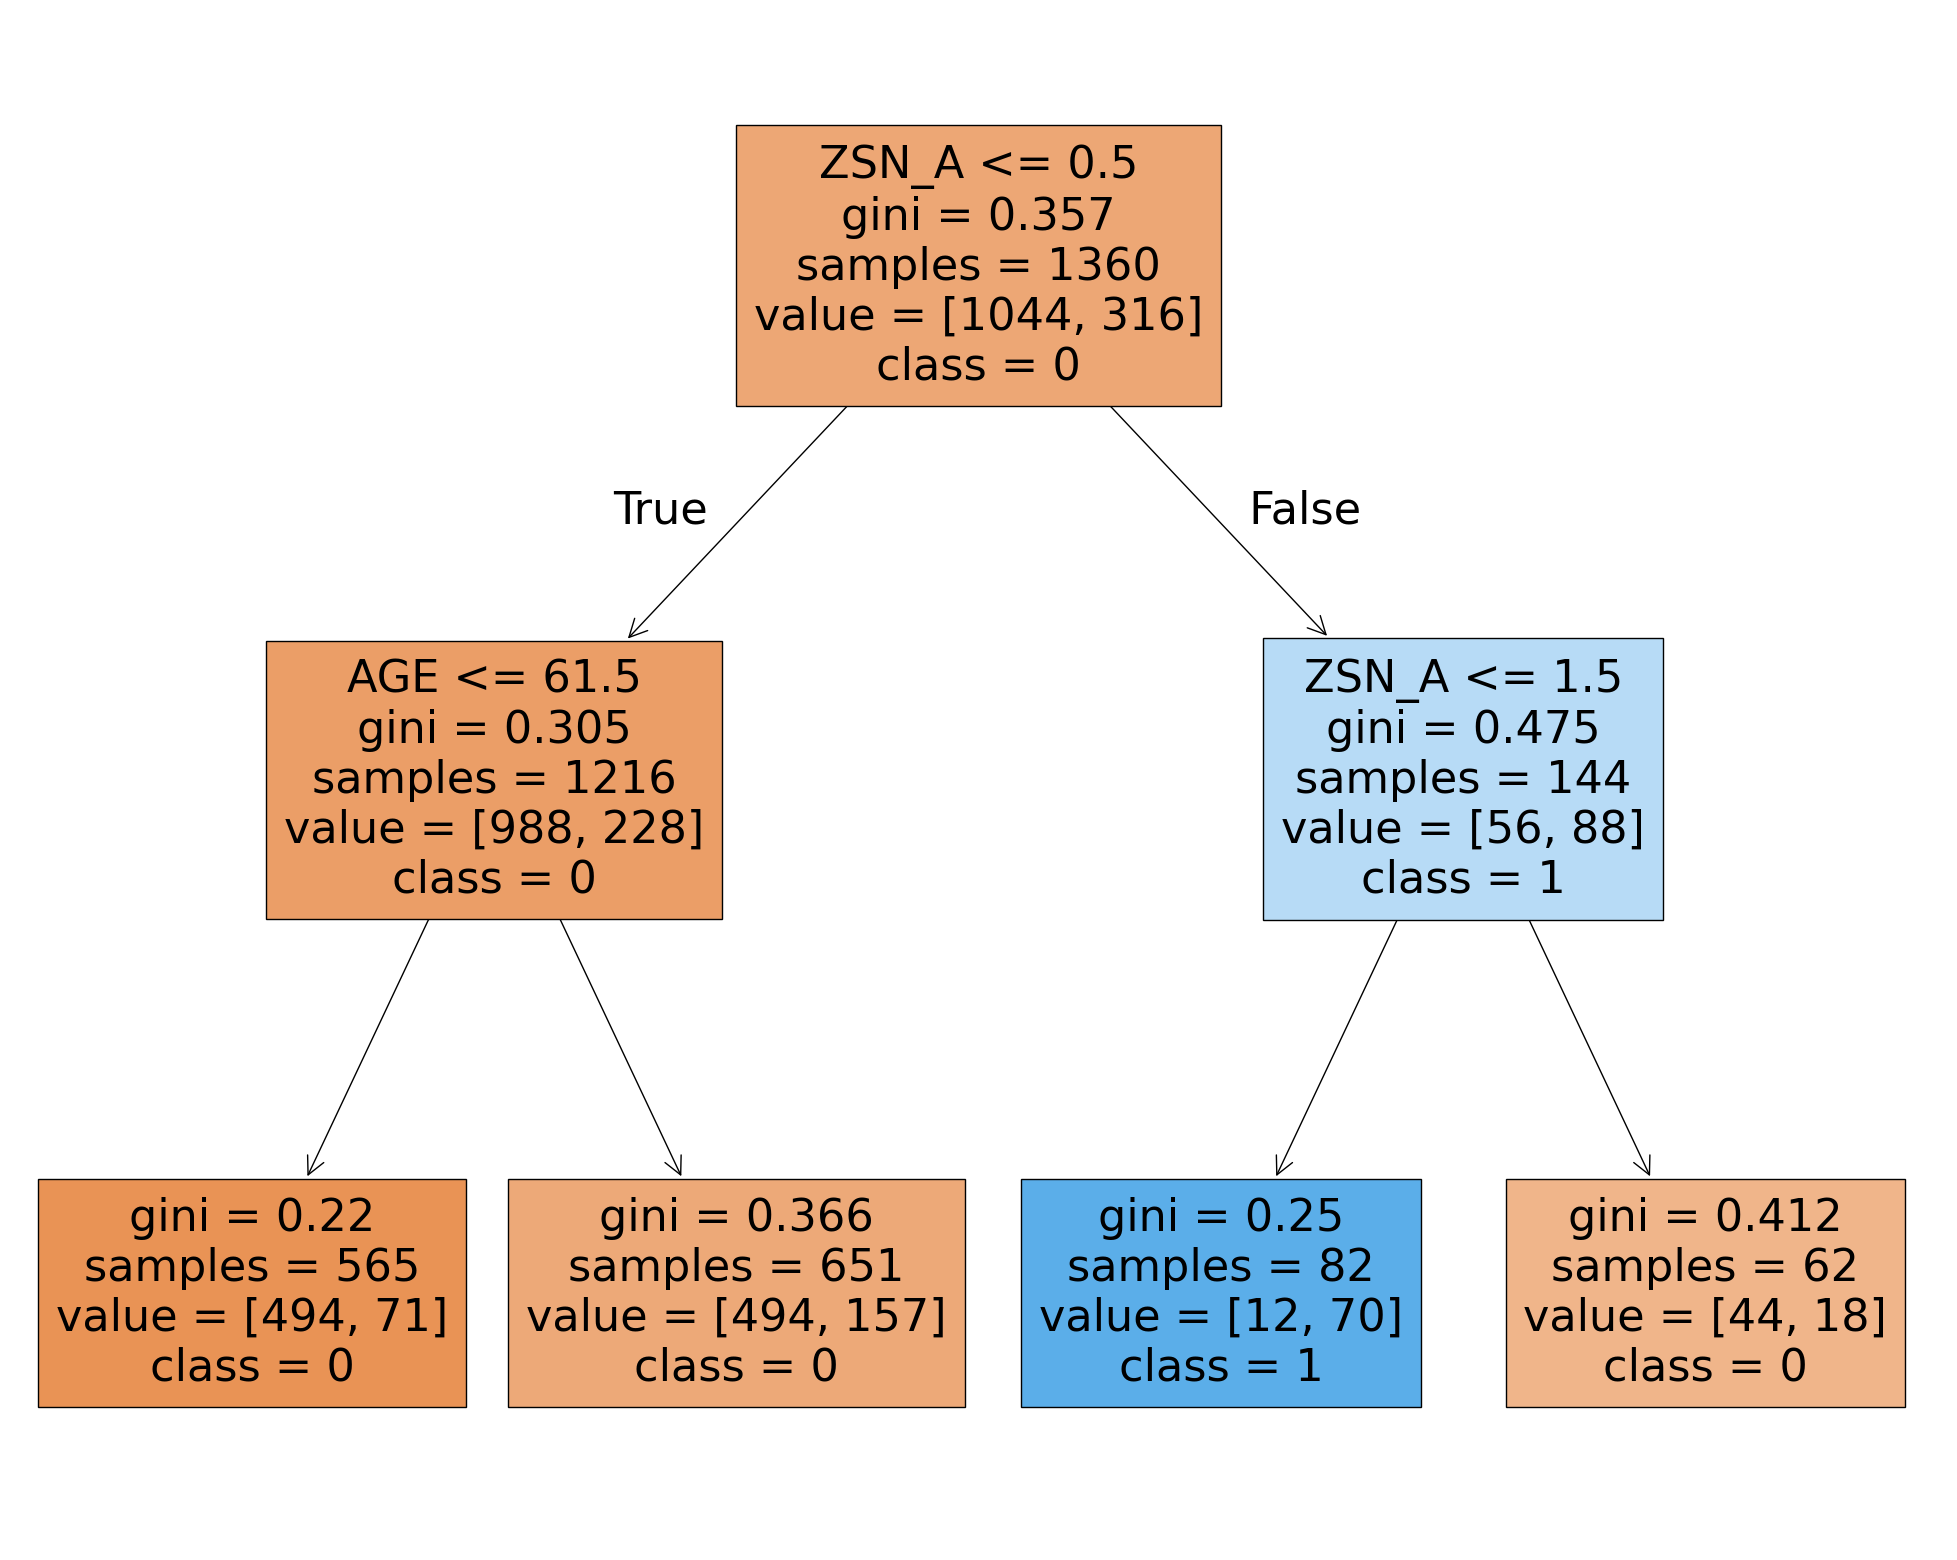

In [5]:
# plot the tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtree, feature_names=data.columns.values.tolist(), class_names=['0','1'], filled=True)

What do we observe? Well, look at the right side of the tree: that branch corresponds to ZSN_A > 0. More precisely, when ZSN_A = 1 (third leaf node when counting from left to right), the complication (ZSN = 1) is predicted whereas for ZSN_A > 1, it predicts ZSN = 0, i.e. no complication. We find that strange, right?

In [6]:
model = XGBClassifier()
model.fit(X_train.values, y_train.values)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [7]:
# Fit an explainer
explainer = shap.TreeExplainer(model)
# Calculates the SHAP values - may take some time
shap_values = explainer.shap_values(X_test)

[10:41:53] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


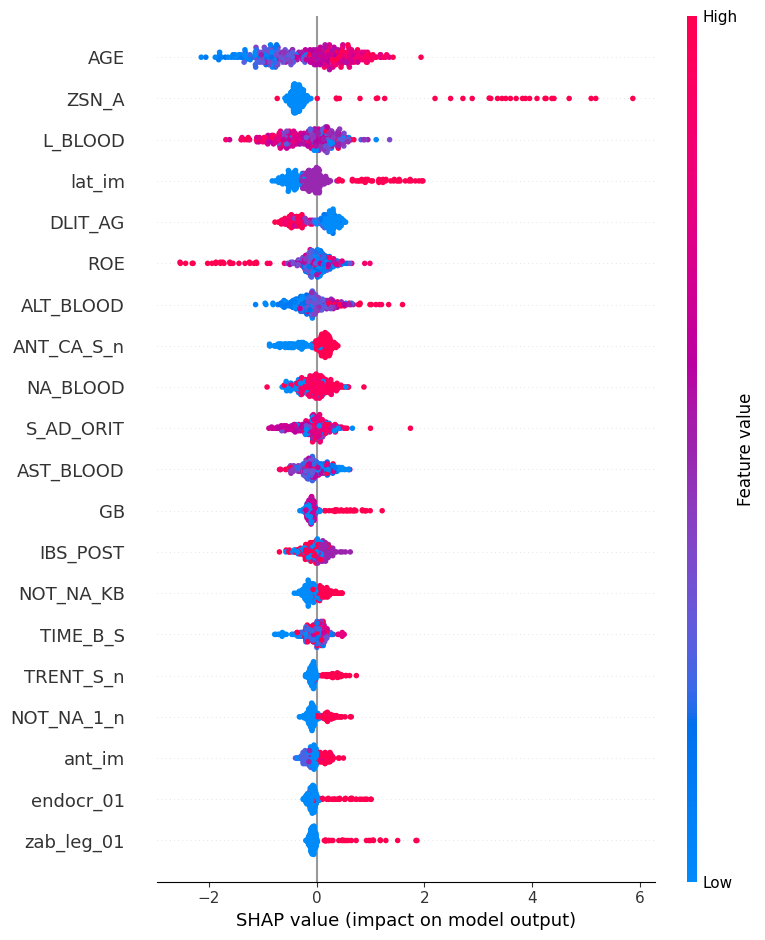

In [8]:
# we make a summary plot to see the overall importance of the features -> ZSN_A is most important!
shap.summary_plot(shap_values, X_test)

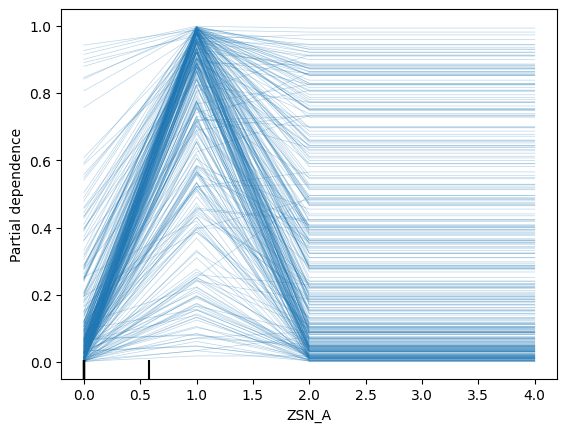

In [9]:
# select a feature, then create an individual conditional expectation plot 
# (using PDP plot, with kind = "individual")
# here, we use the feature ZSN_A which we found to be most important above
features = [9]
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='individual')

We have the same finding as with the tree: for ZSN_A = 1 there is a large increase in probability for predicting the complication (ZSN = 1), for all other values is is much lower!